In [4]:
from coredotfinance.data import KrxReader
import pandas as pd
krx = KrxReader()
company_df = krx.listed_company()
dataframe = krx.read_date('2022-07-01', kor=True)

In [ ]:
import pandas as pd
import numpy as np
import requests
import lxml
from bs4 import BeautifulSoup
from requests import Response
import re

headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'}

url_upjong = "https://finance.naver.com/sise/sise_group.naver?type=upjong"
res = requests.get(url_upjong, headers=headers)
page_soup = BeautifulSoup(res.text, "lxml")
summary_html = page_soup.select('td a')

upjong_list = pd.DataFrame(re.findall('no=(.+?)">(.+?)</a>',str(summary_html)))
upjong_list = upjong_list.rename(columns={0:"no",1:"upjong"}).sort_values(by=['upjong']).reset_index(drop=True)
upjong_list.no = upjong_list.no.str.zfill(3)

request_upjong_url = "https://finance.naver.com/sise/field_submit.naver?menu=upjong&returnUrl=http%3A%2F%2Ffinance.naver.com%2Fsise%2Fsise_group_detail.naver%3Ftype%3Dupjong%26no%3D"
request_url1 = "&fieldIds=market_sum&fieldIds=property_total&fieldIds=debt_total&fieldIds=sales"
request_url2 = "&fieldIds=operating_profit&fieldIds=net_income&fieldIds=eps&fieldIds=dividend"
#request_url3 = "&fieldIds=per&fieldIds=roe&fieldIds=roa&fieldIds=listed_stock_cnt&fieldIds=pbr&fieldIds=reserve_ratio"

upjong = pd.DataFrame()
for i in (upjong_list['no'].to_list()):
    temp = pd.DataFrame()
    for j in ([request_url1,request_url2]):
        res = requests.get(request_upjong_url+i+j, headers=headers)
        page_soup = BeautifulSoup(res.text, "lxml")
        upjong_data_html = page_soup.select_one('#contentarea > div:nth-child(5)')
        col = [item.get_text().strip() for item in upjong_data_html.select('thead th')]
        col = [x for x in col if x not in ['종목명','토론실']]
        row = [item.get_text().strip() for item in upjong_data_html.select('tbody a')]
        row = list(filter(None,row))
        num = np.array([item.get_text().strip() for item in upjong_data_html.select('td.number')])
        num.resize(len(row),len(col))
        df = pd.DataFrame(num, columns=col,index=row).drop(columns=['현재가','전일비','등락률'])
        df['Sector'] = upjong_list[upjong_list.no==i].upjong.iat[0]
        temp = pd.concat([temp,df], axis = 1)
    #temp.index = pd.MultiIndex.from_product([[upjong_list[upjong_list.no==i].upjong.iat[0]],temp.index],names=["Sector","Stock"])
    upjong = pd.concat([upjong,temp], axis = 0)
    
with pd.ExcelWriter('upjong.xlsx', engine='openpyxl') as writer:
    upjong.to_excel(writer)

In [113]:
listed_company_df = pd.merge(company_df, dataframe, on='종목코드', how='inner')
filtered_companies = listed_company_df[['종목명_x', '시장구분_x', '업종명', '상장주식수_x','업종코드', '시가총액']]

#KOSPI
KOSPI_companies = filtered_companies[filtered_companies['시장구분_x']=="KOSPI"].sort_values(by=['시가총액'])
KOSPI_companies = KOSPI_companies.loc[KOSPI_companies['시가총액'] < 10**12] 

KOSPI_groupby_sum = KOSPI_companies.groupby('업종명')['시가총액'].agg(시가총액='sum', MyCount='count').sort_values(by=['시가총액'])
KOSPI_groupby_mean = KOSPI_companies.groupby('업종명').mean().sort_values(by=['시가총액'])

print(KOSPI_groupby_sum.to_string())
print(KOSPI_groupby_mean.to_string())

                                              시가총액  MyCount
업종명                                                        
편조원단 제조업                               23520000000        1
전구 및 조명장치 제조업                          31771777950        1
섬유 의복 신발 및 가죽제품 소매업                    43181682090        1
건물설비 설치 공사업                            44055160000        1
자동차 부품 및 내장품 판매업                       44876694040        1
스포츠 서비스업                               47523135900        1
기타 전기장비 제조업                            52740000000        1
그외 기타 제품 제조업                           55732648005        1
그외 기타 운송장비 제조업                         58932367803        1
금속 주조업                                 64565442400        1
도축 육류 가공 및 저장 처리업                      96219510420        1
건축자재 철물 및 난방장치 도매업                    103017291300        1
제재 및 목재 가공업                           103526216465        1
기타 종이 및 판지 제품 제조업                     115565165800        1
보험 및 연금관련 서비스업                        12

              종목명   시장구분      영업이익    시가총액      Sector        매출액
1344    엔에이치스팩19호  KOSPI      -1.0    1077        창업투자        0.0
154       NH프라임리츠  KOSPI      39.0     855         부동산       41.0
1885      코람코더원리츠  KOSPI      28.0    2165         부동산       46.0
731      미래에셋맵스리츠  KOSPI      31.0     842         부동산       58.0
705        모두투어리츠  KOSPI      34.0     373         부동산       61.0
1629      이지스밸류리츠  KOSPI      52.0    1863         부동산       69.0
1607         이스타코  KOSPI      -3.0     525         부동산       71.0
1287         에이리츠  KOSPI      46.0     247         부동산       73.0
727        미래아이앤지  KOSPI       9.0     394       IT서비스       78.0
728     미래에셋글로벌리츠  KOSPI     -32.0    1353         부동산       83.0
1628    이지스레지던스리츠  KOSPI      89.0    1011         부동산       92.0
1110      쎌마테라퓨틱스  KOSPI     -49.0    1574        판매업체       96.0
1643        인바이오젠  KOSPI     -79.0     844   섬유의류신발호화품      105.0
1084    신한서부티엔디리츠  KOSPI      57.0    2686         부동산      106.0
748       

/Users/Welcome/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Welcome/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Welcome/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Welcome/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/Welcome/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing fr

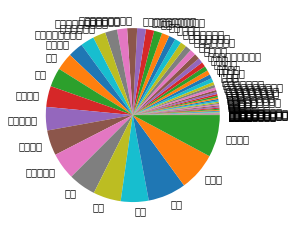

In [118]:

import matplotlib.pyplot as plt
upjong = pd.read_excel('upjong_merged.xlsx', engine='openpyxl')

filtered_companies = upjong[['종목명', '시장구분', '영업이익', '시가총액', 'Sector','매출액']]

KOSPI_companies = filtered_companies[filtered_companies['시장구분'] == "KOSPI"]

KOSPI_companies = KOSPI_companies.apply(lambda x: x.str.replace(',', ''))
KOSPI_companies['영업이익'] = pd.to_numeric(KOSPI_companies['영업이익'])
KOSPI_companies['매출액'] = pd.to_numeric(KOSPI_companies['매출액'])

KOSPI_companies = KOSPI_companies.dropna()
KOSPI_companies = KOSPI_companies.sort_values(by=['매출액'])
#KOSPI_companies = KOSPI_companies.loc[KOSPI_companies['매출액'] < 10**6] 

KOSPI_groupby_sum = KOSPI_companies.groupby('Sector')['매출액'].agg(매출액='sum',  MyCount='count').sort_values(by=['매출액'])

plt.pie(KOSPI_groupby_sum['매출액'].to_list(), labels= KOSPI_groupby_sum.index.to_list())
#plt.hist(KOSPI_groupby_sum['매출액'].to_list())
print(KOSPI_companies.to_string())
print(KOSPI_groupby_sum.to_string())